In [1]:
import sys
sys.path.append('../')

import torch, time
import numpy as np
import torch.nn as nn
import random, os, math
import matplotlib.pyplot as plt
from MCTensor.MCModule import *
from MCTensor import MCOptim
from tqdm import tqdm
from sklearn import datasets, preprocessing
from sklearn.model_selection import train_test_split
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

###############################################################################
d16 = torch.float16
d32 = torch.float32
d64 = torch.float64
cpu = torch.device("cpu")
gpu = torch.device(type='cuda', index=0)
# set device
device = gpu

In [2]:
def cancer_data(seed=1234):
    breastCancer = datasets.load_breast_cancer()
    X = breastCancer.data
    y = breastCancer.target
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test, y_train, y_test

In [3]:
X_train, X_test, y_train, y_test = cancer_data()
def get_dataset(dtype, device):    
    X_train64, X_test64 = torch.from_numpy(X_train).to(
        device), torch.from_numpy(X_test).to(device)
    y_train64, y_test64 = torch.from_numpy(y_train).to(
        device).to(d64), torch.from_numpy(y_test).to(device).to(d64)
    if dtype == d64:
        return X_train64, X_test64, y_train64, y_test64
    elif dtype == d32:
        X_train32, y_train32 = X_train64.to(d32), y_train64.to(d32)
        X_test32, y_test32 = X_test64.to(d32), y_test64.to(d32)
        return X_train32, X_test32, y_train32, y_test32
    else:  # dtype = d16
        X_train16, y_train16 = X_train64.to(d16), y_train64.to(d16)
        X_test16, y_test16 = X_test64.to(d16), y_test64.to(d16)
        return X_train16, X_test16, y_train16, y_test16

In [4]:
def MCSGD(model, lr=0.001):
    grad = model.linear.weight.grad
    new = model.linear.weight.detach() - lr*grad
    model.linear.weight.fc.data.copy_(new.fc.data)
    model.linear.weight.data.copy_(new.data)
    return

def zero_grad(model):
    if model.linear.weight.grad is not None:
        model.linear.weight.grad.zero_()

class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, dtype=d16, device=cpu,
                 init_weight=None):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, 1, dtype=dtype,
                                      device=device, bias=False)
        if init_weight is not None:
            self.linear.weight.data.copy_(init_weight.data.to(dtype)) 

    def forward(self, x):
        x = self.linear(x)
        x = torch.sigmoid(x)
        return x


class MCLogisticRegression(nn.Module):
    def __init__(self, input_dim, nc, dtype=d32, device=cpu, init_weight=None):
        super(MCLogisticRegression, self).__init__()
        self.linear = MCLinear(input_dim, 1, nc, bias=False, dtype=dtype,
                               device=device, _weight=init_weight)

    def forward(self, x):
        x = self.linear(x)
        x = x.tensor[..., 0]
        x = torch.sigmoid(x)
        return x
    
    def parameters(self):
        return self.linear.parameters()


In [5]:
def init_weights(seed=1234):
    torch.manual_seed(seed=seed)
    std = 1./math.sqrt(30)
    init_weights = torch.zeros(30, 1)
    init_weights.data.uniform_(-std, std)
    return 0.1*init_weights

init_weight = init_weights()

In [10]:
def train_MC(dtype, nc=2, epochs=1000, lr=0.001, device=device,
             init_seed=1234):
    init_weight = init_weights(init_seed)
    X_train, X_test, y_train, y_test = get_dataset(dtype, device)
    LOSS, LOSS_test = [], []
    acc, acc_test = [], []
    model = MCLogisticRegression(len(X_train[0]), nc, dtype=dtype, device=device,
                                 init_weight=init_weight.t())
    criterion = torch.nn.BCELoss()
    mc_optimizer = MCOptim.MCSGD(model.parameters(), lr)

    def get_acc(output, target):
        predicted = torch.squeeze(output).to(cpu).to(d64).round()
        n_correct = torch.sum(predicted == target.to(cpu).to(d64)).item()
        return 100 * n_correct/target.size(0)

    for epoch in tqdm(range(epochs)):
        mc_optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(torch.squeeze(output), y_train)
        loss_d64 = criterion(torch.squeeze(
            output).to(d64), y_train.to(d64)).item()
        LOSS.append(loss_d64)
        acc.append(get_acc(output, y_train))
        loss.backward()
        mc_optimizer.step()

        # getting test result
        output_test = model(X_test)
        loss_d64 = criterion(torch.squeeze(
            output_test).to(d64), y_test.to(d64)).item()
        acc_test.append(get_acc(output_test, y_test))
        LOSS_test.append(loss_d64)
    return LOSS, acc, LOSS_test, acc_test


In [7]:
def train_torch(dtype, epochs=1000, lr=0.001, device=device,
                init_seed=1234):
    init_weight = init_weights(init_seed)
    X_train, X_test, y_train, y_test = get_dataset(dtype, device)
    LOSS, LOSS_test = [], []
    acc, acc_test = [], []
    model = LogisticRegression(len(X_train[0]), dtype=dtype, device=device,
                               init_weight=init_weight.t())
    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    def get_acc(output, target):
        predicted = torch.squeeze(output).to(cpu).to(d64).round()
        n_correct = torch.sum(predicted == target.to(cpu).to(d64)).item()
        return 100 * n_correct/target.size(0)

    for epoch in tqdm(range(epochs)):
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(torch.squeeze(output), y_train)
        with torch.no_grad():
            output_test = model(X_test)
            loss_d64 = criterion(torch.squeeze(
                output_test).to(d64), y_test.to(d64)).item()
            acc_test.append(get_acc(output_test, y_test))
            LOSS_test.append(loss_d64)
            loss_d64 = criterion(torch.squeeze(
                output).to(d64), y_train.to(d64)).item()
            LOSS.append(loss_d64)
            acc.append(get_acc(output, y_train))
            #print("iter:", epoch, "loss is:", loss_d64, "acc:", get_acc(output_test, y_test))
        loss.backward()
        optimizer.step()
        
    return LOSS, acc, LOSS_test, acc_test

In [8]:
epochs = 2000; lr = 3e-3
loss16, acc16, loss_test16, acc_test16 = train_torch(d16, epochs=epochs, lr=lr)
loss32, acc32, loss_test32, acc_test32 = train_torch(d32, epochs=epochs, lr=lr)
loss64, acc64, loss_test64, acc_test64 = train_torch(d64, epochs=epochs, lr=lr)
print("Final training loss for torch models:", loss16[-1], loss32[-1], loss64[-1])
print("Final training acc for torch models:", acc16[-1], acc32[-1], acc64[-1])

100%|██████████| 2000/2000 [00:07<00:00, 262.86it/s]

Final training loss for torch models: 0.13651601742202124 0.11454217750318217 0.11454216313373707
Final training acc for torch models: 98.24175824175825 98.24175824175825 98.24175824175825


In [11]:
start = time.time()
epochs = 2000; lr = 3e-3
loss_nc1, acc_nc1, loss_test_nc1, acc_test_nc1 = train_MC(d16, nc=1, epochs=epochs, lr=lr)
loss_nc2, acc_nc2, loss_test_nc2, acc_test_nc2 = train_MC(d16, nc=2, epochs=epochs, lr=lr)
loss_nc3, acc_nc3, loss_test_nc3, acc_test_nc3 = train_MC(d16, nc=3, epochs=epochs, lr=lr)
print("time spent:", time.time() - start)
print("Final training loss for MCT models:", loss_nc1[-1], loss_nc2[-1], loss_nc3[-1])
print("Final training acc for MCT models:", acc_nc1[-1], acc_nc2[-1], acc_nc3[-1])

100%|██████████| 2000/2000 [11:10<00:00,  2.98it/s]

time spent: 1392.0937702655792
Final training loss for MCT models: 0.13648226954985537 0.11454331455370008 0.11454331455370008
Final training acc for MCT models: 98.24175824175825 98.24175824175825 98.24175824175825


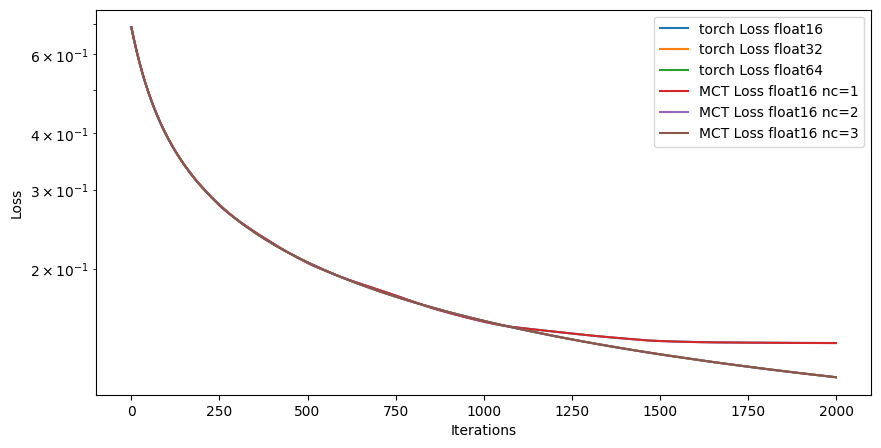

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(range(epochs), loss16, label="torch Loss float16")
plt.plot(range(epochs), loss32, label="torch Loss float32")
plt.plot(range(epochs), loss64, label="torch Loss float64")
plt.plot(range(epochs), loss_nc1, label="MCT Loss float16 nc=1")
plt.plot(range(epochs), loss_nc2, label="MCT Loss float16 nc=2")
plt.plot(range(epochs), loss_nc3, label="MCT Loss float16 nc=3")
plt.xlabel('Iterations')
# plt.xscale('log')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.show()